> [Amanda L Richer, Kent A Riemondy, Lakotah Hardie, Jay R Hesselberth, **Simultaneous measurement of biochemical phenotypes and gene expression in single cells**, *Nucleic Acids Research*, (2020)](https://doi.org/10.1093/nar/gkaa240)

> **Dataset:** Cell line models targeted with CRISPR technology and UNG<sup>KO</sup> and RNASEH2C<sup>KO</sup> used for single cell RNA experssion experiments (haicut-seq) in 3 timepoints. 
> - **Cell line:** Hap1 UNG<sup>KO</sup> (HZGHC001531c012) and RNASEH2C<sup>KO</sup> (HZGHC004633c003) cells.


**Aim:** Find Transcription Factor (TF) and motifs with potential transcription regulatory functions in DNA repair phenotype 

**Method:** Gene Regulatory Network (GRN) analysis of time-series scRNA-seq experiments to 

## Gene-expression Regulatory Network

- [Single-cell network biology for resolving cellular heterogeneity in human diseases](https://doi.org/10.1038/s12276-020-00528-0)

> [**Evaluating methods of inferring gene regulatory networks highlights their lack of performance for single cell gene expression data**](https://doi.org/10.1186/s12859-018-2217-z)

> 1. We found that single cell network inference methods do not necessarily have better performance than general methods, and even for the method that performed well for simulated data (SCODE), it did not have a higher prediction accuracy than other methods for the experimental single cell data. 
> 2. In addition, we found that when applied to simulated data without drop-out, **GENIE3** was the best performer amongst all general methods, while this did not generalize to the simulated ‘single cell’ data where drop-out was induced. 
> 3. From this study, we therefore conclude that for single cell data, either generated from experiments or simulations, these networks methods had consistently poor performance for reconstructing networks.
> 4. Lastly, the PCA analysis shows that SCODE had a distinct pattern of prediction, while even the presumably similar methods (e.g., ARACNE and CLR are considered to be similar) did not consistently cluster together in the plots, indicating that their network topology was not necessarily more similar to each other than the other methods.
> 5. **Reconstructing GRNs from gene expression data has been one of the most important topics in systems biology.** Therefore, evaluating the performance of existing algorithms and understanding their limitations when applied to a newer wave of data, such as single cell gene expression data, is extremely helpful to facilitate further development of new methodologies that are specific for single cells. Such models would further provide new opportunities to understand cell-to-cell heterogeneity, and other biologically interesting questions such as stem cell differentiation and cancer development.



> [**PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data**](https://www.biorxiv.org/content/10.1101/2020.12.18.423482v1)

> PySCNet accommodates an extensive variety of GRN construction algorithms, graph based
techniques and a user-friendly interface to investigate regulatory relationships among genes and
transcription factors from single-cell RNA-seq data. Instead of following the mainstream analysis
on cell behaviour, PySCNet opens a window to systematically inspect gene-gene / TF
communication at single cell resolved level. 
https://github.com/MingBit/PySCNet


> ### `GENIE3`
> https://github.com/vahuynh/GENIE3

> [GENIE3 bioconductor](https://bioconductor.org/packages/release/bioc/html/GENIE3.html)

> [**dynGENIE3: dynamical GENIE3 for the inference of gene networks from time series expression data**
](https://www.nature.com/articles/s41598-018-21715-0)

> **The elucidation of gene regulatory networks is one of the major challenges of systems biology.** Measurements about genes that are exploited by network inference methods are typically available either in the form of steady-state expression vectors or time series expression data. In our previous work, we proposed the GENIE3 method that exploits variable importance scores derived from Random forests to identify the regulators of each target gene. This method provided state-of-the-art performance on several benchmark datasets, but it could however not specifically be applied to time series expression data. We propose here an adaptation of the GENIE3 method, called dynamical GENIE3 (dynGENIE3), for handling both time series and steady-state expression data. 
> https://github.com/vahuynh/dynGENIE3

# pySCENIC

> `pySCENIC` is a lightning-fast python implementation of the SCENIC pipeline (Single-Cell rEgulatory Network Inference and Clustering) which enables biologists to infer transcription factors, gene regulatory networks and cell types from single-cell RNA-seq data.

- [SCENIC: single-cell regulatory network inference and clustering](https://www.nature.com/articles/nmeth.4463)
- https://scenic.aertslab.org/
- https://github.com/aertslab/pySCENIC
<img src="https://scenic.aertslab.org/images/scenic_workflow_v2.png" width="700" align="center"/>

https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb

In [1]:
import os, glob, re, pickle
from functools import partial
from collections import OrderedDict
import operator as op
from cytoolz import compose

import pandas as pd
import seaborn as sns
import numpy as np
import scanpy as sc
import anndata as ad
import loompy as lp
import matplotlib as mpl
import matplotlib.pyplot as plt

from pyscenic.export import export2loom, add_scenic_metadata
from pyscenic.utils import load_motifs
from pyscenic.transform import df2regulons
from pyscenic.aucell import aucell
from pyscenic.binarization import binarize
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_binarization, plot_rss

from IPython.display import HTML, display

Write filtered `loom` file:

In [2]:
adata = sc.read_h5ad('preprocessing/mix.h5ad.gz')
f_loom_path_scenic = 'preprocessing/mix.loom'

In [3]:
# # create basic row and column attributes for the loom file:
# row_attrs = {
#     "Gene": np.array(adata.var_names) ,
# }
# col_attrs = {
#     "CellID": np.array(adata.obs_names) ,
#     "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
#     "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
# }
# lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)


### Download resources

In [4]:
!mkdir SCENIC
!mkdir SCENIC/resources

mkdir: SCENIC: File exists
mkdir: SCENIC/resources: File exists


_Download auxiliary files: list of TFs, ranking databases and motif annotations (for human, in this example):_

source: https://www.nature.com/articles/s41596-020-0336-2

In [5]:
ls SCENIC/resources/

hs_hgnc_tfs.txt


## SCENIC steps

In [6]:
RESOURCES_FOLDERNAME = "SCENIC/resources"
RESULTS_FOLDERNAME = "SCENIC/results"
FIGURES_FOLDERNAME = "SCENIC/figures"

In [7]:
BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

In [8]:
sc.settings.figdir = FIGURES_FOLDERNAME

In [9]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 4

Auxilliary functions.

In [10]:
def savesvg(fname: str, fig, folder: str=FIGURES_FOLDERNAME) -> None:
    """
    Save figure as vector-based SVG image format.
    """
    fig.tight_layout()
    fig.savefig(os.path.join(folder, fname), format='svg')

In [11]:
def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', -1)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

## STEP 1: Gene regulatory network inference, and generation of co-expression modules
### Phase Ia: GRN inference using the GRNBoost2 algorithm
For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. 

We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier. 

**Output:** List of adjacencies between a TF and its targets stored in ADJACENCIES_FNAME.

In [12]:
DATASET_ID = 'mix'

ADJACENCIES_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.adjacencies.tsv'
MOTIFS_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.motifs.csv'
REGULONS_DAT_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.regulons.dat'
AUCELL_MTX_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.auc.csv'
BIN_MTX_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.bin.csv'
THR_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.thresholds.csv'
ANNDATA_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.h5ad'
LOOM_FNAME = f'{RESULTS_FOLDERNAME}/{DATASET_ID}.loom'

In [13]:
# transcription factors
HUMAN_TFS_FNAME = f'{RESOURCES_FOLDERNAME}/hs_hgnc_tfs.txt'
# ranking databases
RANKING_DBS_FNAME = f'{RESOURCES_FOLDERNAME}/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather'
# motif databases
MOTIF_ANNOTATIONS_FNAME = f'{RESOURCES_FOLDERNAME}/motifs-v9-nr.hgnc-m0.001-o0.0.tbl'

In [14]:
mkdir -p SCENIC/results

In [15]:
# !pyscenic grn {f_loom_path_scenic} {HUMAN_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 4

https://pyscenic.readthedocs.io/en/latest/faq.html#i-am-having-problems-with-dask

In [ ]:
!arboreto_with_multiprocessing.py \
    {f_loom_path_scenic} \
    {HUMAN_TFS_FNAME} \
    --method genie3 \
    --output {ADJACENCIES_FNAME} --num_workers 8

Loaded expression matrix of 4865 cells and 18292 genes in 2.8737986087799072 seconds...
Loaded 1839 TFs...
starting genie3 using 8 processes...
 32%|██████████▊                       | 5833/18292 [4:40:23<7:47:22,  2.25s/it]

Read in the adjacencies matrix:

In [12]:
adjacencies = pd.read_csv(ADJACENCIES_FNAME, index_col=False, sep='\t')

In [39]:
adjacencies.to_csv(f'{ADJACENCIES_FNAME}.gz', index=None, compression='gzip', sep='\t')

In [26]:
ADJACENCIES_FNAME

'SCENIC/results/mix.adjacencies.tsv'

In [17]:
%%time 
adjacencies = pd.read_csv(f'{ADJACENCIES_FNAME}.gz', index_col=False, sep='\t')

CPU times: user 14.7 s, sys: 1.29 s, total: 16 s
Wall time: 16.1 s


In [282]:
adjacencies.head()

,TF,target,importance
0,RPS4X,RPL36A,0.065688
1,RPS4X,RPL10,0.062242
2,RPS10,RPS16,0.060746
3,RPL35,RPS10,0.060129
4,RPS10,RPS15A,0.060007


## STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

**Output:** List of adjacencies between a TF and its targets stored in MOTIFS_FNAME.

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

In [18]:
%%time 
df_motifs = load_motifs(MOTIFS_FNAME)

CPU times: user 10.5 s, sys: 217 ms, total: 10.7 s
Wall time: 10.8 s


In [19]:
df_motifs.head()

Enrichment            \
                                                         AUC       NES   
TF   MotifID                                                             
ALX1 taipale__ALX4_DBD_NTAATYNRATTAN                0.065212  3.014227   
ATF1 dbcorrdb__ATF3__ENCSR000BKC_1__m1              0.056011  3.726154   
     dbcorrdb__ATF3__ENCSR000DOG_1__m1              0.055088  3.593066   
     dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1   0.051899  3.133225   
     dbcorrdb__BRCA1__ENCSR000EDB_1__m1             0.053433  3.354375   

                                                                         \
                                                  MotifSimilarityQvalue   
TF   MotifID                                                              
ALX1 taipale__ALX4_DBD_NTAATYNRATTAN                           0.000023   
ATF1 dbcorrdb__ATF3__ENCSR000BKC_1__m1                         0.000000   
     dbcorrdb__ATF3__ENCSR000DOG_1__m1                         0.000197   
     dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1              0.000646   
     dbcorrdb__BRCA1__ENCSR000EDB_1__m1                        0.000112   

                                                                       \
                                                  OrthologousIdentity   
TF   MotifID                                                            
ALX1 taipale__ALX4_DBD_NTAATYNRATTAN                              1.0   
ATF1 dbcorrdb__ATF3__ENCSR000BKC_1__m1                            1.0   
     dbcorrdb__ATF3__ENCSR000DOG_1__m1                            1.0   
     dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1                 1.0   
     dbcorrdb__BRCA1__ENCSR000EDB_1__m1                           1.0   

                                                                                                      \
                                                                                          Annotation   
TF   MotifID                                                                                           
ALX1 taipale__ALX4_DBD_NTAATYNRATTAN               motif similar to cisbp__M5311 ('ALX1[gene ID: ...   
ATF1 dbcorrdb__ATF3__ENCSR000BKC_1__m1             motif similar to dbcorrdb__ATF1__ENCSR000DNZ_1...   
     dbcorrdb__ATF3__ENCSR000DOG_1__m1             motif similar to transfac_pro__M01861 ('V$ATF1...   
     dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1  motif similar to dbcorrdb__ATF1__ENCSR000DNZ_1...   
     dbcorrdb__BRCA1__ENCSR000EDB_1__m1            gene is annotated for similar motif dbcorrdb__...   

                                                                                                      \
                                                                                             Context   
TF   MotifID                                                                                           
ALX1 taipale__ALX4_DBD_NTAATYNRATTAN               (hg38__refseq-r80__10kb_up_and_down_tss.mc9nr,...   
ATF1 dbcorrdb__ATF3__ENCSR000BKC_1__m1             (hg38__refseq-r80__10kb_up_and_down_tss.mc9nr,...   
     dbcorrdb__ATF3__ENCSR000DOG_1__m1             (hg38__refseq-r80__10kb_up_and_down_tss.mc9nr,...   
     dbcorrdb__POLR2AphosphoS2__ENCSR000ECT_1__m1  (hg38__refseq-r80__10kb_up_and_down_tss.mc9nr,...   
     dbcorrdb__BRCA1__ENCSR000EDB_1__m1            (hg38__refseq-r80__10kb_up_and_down_tss.mc9nr,...   

                                                                                                      \
                                                                                         TargetGenes   
TF   MotifID                                                                                           
ALX1 taipale__ALX4_DBD_NTAATYNRATTAN               [(PCGF1, 0.0019230467712708765), (ZNF536, 0.00...   
ATF1 dbcorrdb__ATF3__ENCSR000BKC_1__m1             [(EFNA3, 0.0016309332074794338), (DVL2, 0.0009...   
     dbcorrdb__ATF3__ENCSR000DOG_1__m1             [(EFNA3, 0.0016309332074794338), (

Display the enriched motifs with their associated sequence logos.

In [20]:
display_logos(df_motifs.head())

/Users/abearab/anaconda3/envs/sc-net/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## STEP 4: Cellular enrichment (aka AUCell) from CLI
> It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC. The following histogram gives an idea of the distribution and allows selection of an appropriate threshold. In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses). See the relevant section in the R tutorial for more information.
By using the default setting for `--auc_threshold` of 0.05, we see that 1192 genes are selected for the rankings based on the plot below.

In [19]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
percentiles = np.quantile(nGenesDetectedPerCell,[.01, .05, .10, .50, 1])
print(percentiles)

[ 466.64  665.2   794.   1456.   5278.  ]


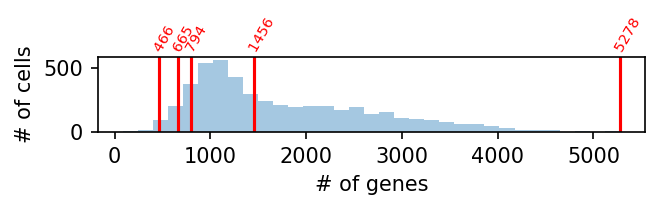

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 1.5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f' {int(x)}', color='red', rotation=60, size='x-small',rotation_mode='anchor')
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()


In [48]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    {MOTIFS_FNAME} \
    --output {AUCELL_MTX_FNAME} \
    --num_workers 8


2021-06-11 07:53:02,910 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-06-11 07:53:10,023 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2021-06-11 07:53:31,590 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2021-06-11 07:53:44,234 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [21]:
auc_mtx = pd.read_csv(f'{AUCELL_MTX_FNAME}',index_col='Cell')

In [22]:
auc_mtx

,ACO1(+),AHR(+),ALX1(+),ARID3A(+),ARX(+),ATF1(+),ATF2(+),ATF3(+),ATF4(+),ATF6(+),...,ZNF595(+),ZNF607(+),ZNF623(+),ZNF674(+),ZNF676(+),ZNF726(+),ZNF730(+),ZNF770(+),ZNF84(+),ZXDC(+)
Cell,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATCCTGT-0,0.000000,0.0,0.000000,0.000000,0.000000,0.025544,0.006703,0.000000,0.118356,0.012783,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011366,0.017912,0.000000
AAACGGGAGGTTCCTA-0,0.011658,0.0,0.000000,0.000000,0.000000,0.017182,0.033698,0.014424,0.094011,0.013904,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008306,0.014962,0.000000
AAAGATGCAATAACGA-0,0.000000,0.0,0.015027,0.000000,0.000000,0.019090,0.000000,0.007963,0.103859,0.012699,...,0.0,0.000000,0.070101,0.000000,0.032865,0.000000,0.000000,0.000000,0.011857,0.000000
AAAGCAAGTATATGGA-0,0.012589,0.0,0.000000,0.000000,0.000000,0.025274,0.000000,0.000000,0.100546,0.009300,...,0.0,0.061967,0.000000,0.000000,0.045902,0.000000,0.000000,0.038601,0.004807,0.097580
AAAGTAGTCGTCACGG-0,0.000000,0.0,0.000000,0.000000,0.000000,0.015099,0.000000,0.015325,0.097078,0.018720,...,0.0,0.049727,0.000000,0.000000,0.000000,0.000000,0.000000,0.011934,0.016461,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TATTACCTCTTTACAC-2,0.000000,0.0,0.000000,0.000000,0.000000,0.029832,0.000000,0.006305,0.041954,0.022859,...,0.0,0.000000,0.000000,0.135519,0.000000,0.049180,0.000000,0.038033,0.017370,0.049649
GCTTGAAGTATTCTCT-2,0.020300,0.0,0.000000,0.000000,0.000000,0.034577,0.000000,0.013175,0.095896,0.008193,...,0.0,0.000000,0.000000,0.023224,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000
TGAAAGAGTAGAGGAA-2,0.011435,0.0,0.000000,0.000000,0.000000,0.023968,0.000000,0.016129,0.070670,0.015301,...,0.0,0.000000,0.000000,0.113661,0.000000,0.027596,0.319672,0.006426,0.008008,0.037471


### STEP 5 - Regulon activity binarization 

In [65]:
help(binarize)

Help on function binarize in module pyscenic.binarization:

binarize(auc_mtx: pandas.core.frame.DataFrame, threshold_overides: Union[Mapping[str, float], NoneType] = None, seed=None, num_workers=1) -> (<class 'pandas.core.frame.DataFrame'>, <class 'pandas.core.series.Series'>)
    "Binarize" the supplied AUC matrix, i.e. decide if for each cells in the matrix a regulon is active or not based
    on the bimodal distribution of the AUC values for that regulon.
    
    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param threshold_overides: A dictionary that maps name of regulons to manually set thresholds.
    :return: A "binarized" dataframe and a series containing the AUC threshold used for each regulon.



In [66]:
bin_mtx, thresholds = binarize(auc_mtx,num_workers=8)

In [67]:
bin_mtx.to_csv(BIN_MTX_FNAME)
thresholds.to_frame().rename(columns={0:'threshold'}).to_csv(THR_FNAME)

___

In [23]:
bin_mtx = pd.read_csv(BIN_MTX_FNAME, index_col=0)
thresholds = pd.read_csv(THR_FNAME, index_col=0).threshold

In [83]:
help(plot_binarization)

Help on function plot_binarization in module pyscenic.plotting:

plot_binarization(auc_mtx: pandas.core.frame.DataFrame, regulon_name: str, threshold: float, bins: int = 200, ax=None) -> None
    Plot the "binarization" process for the given regulon.
    
    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param regulon_name: The name of the regulon.
    :param bins: The number of bins to use in the AUC histogram.
    :param threshold: The threshold to use for binarization.



### Find time specific activated TF 
Here I aim to filter AUC scores based on time labels to find activated TFs. 

In [1]:
import seaborn as sns; sns.set_theme(color_codes=True)

In [115]:
%%time 
adata = sc.read_h5ad('preprocessing/mix.h5ad.gz')

adata.obs['time'] = adata.obs['time'].astype(str)

adata.obs['Uracil-repair-time'] = adata.obs[['Uracil-repair','time']].agg('-'.join, axis=1)
adata.obs['riboG-repair-time'] = adata.obs[['riboG-repair','time']].agg('-'.join, axis=1)

CPU times: user 1.35 s, sys: 201 ms, total: 1.55 s
Wall time: 1.61 s


In [116]:
auc_mtx = pd.read_csv('SCENIC/results/mix.auc.csv',index_col='Cell')

#### riboG-repair-time

In [28]:
rss_rG = regulon_specificity_scores(auc_mtx, adata.obs['riboG-repair-time'])
rss_rG = rss_rG[['none' not in i for i in rss_rG.index]]

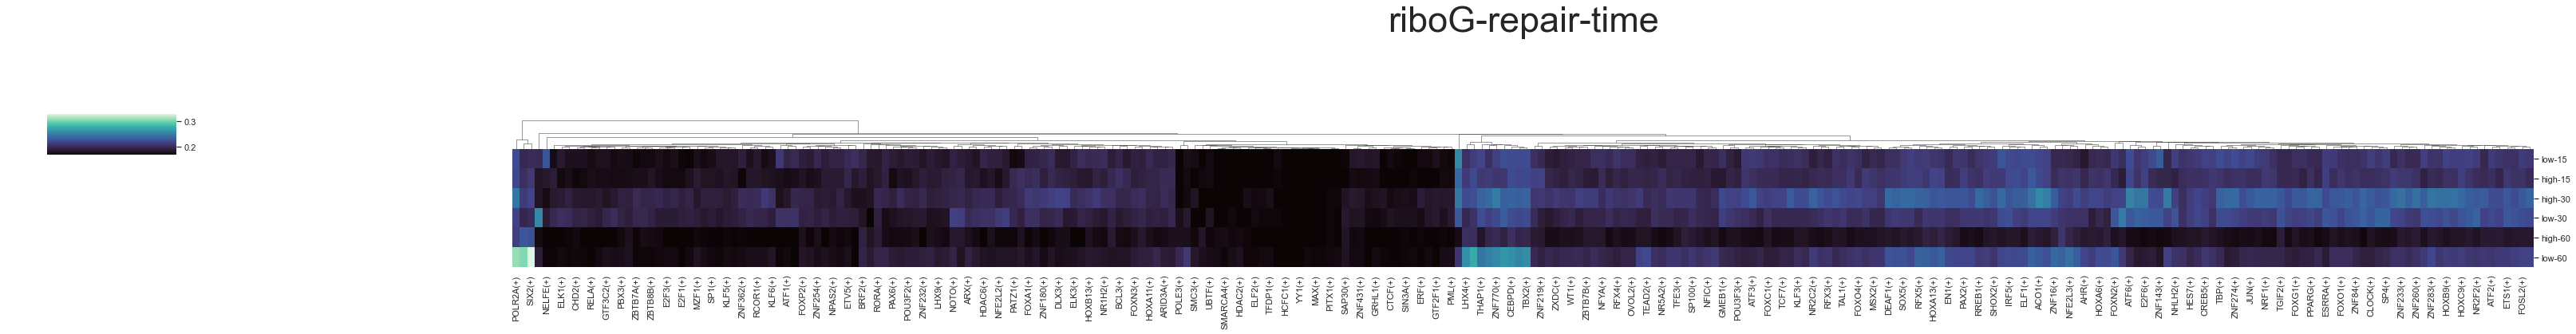

In [11]:
g = sns.clustermap(rss_rG,figsize=(45,4),
                   row_cluster=False,
                   cmap="mako",
                  )
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)
_ = g.ax_heatmap.set_title('riboG-repair-time\n\n\n',fontsize=45)

#### Uracil-repair-time

In [17]:
rss_dU = regulon_specificity_scores(auc_mtx, adata.obs['Uracil-repair-time'])
rss_dU = rss_dU[['none' not in i for i in rss_dU.index]]

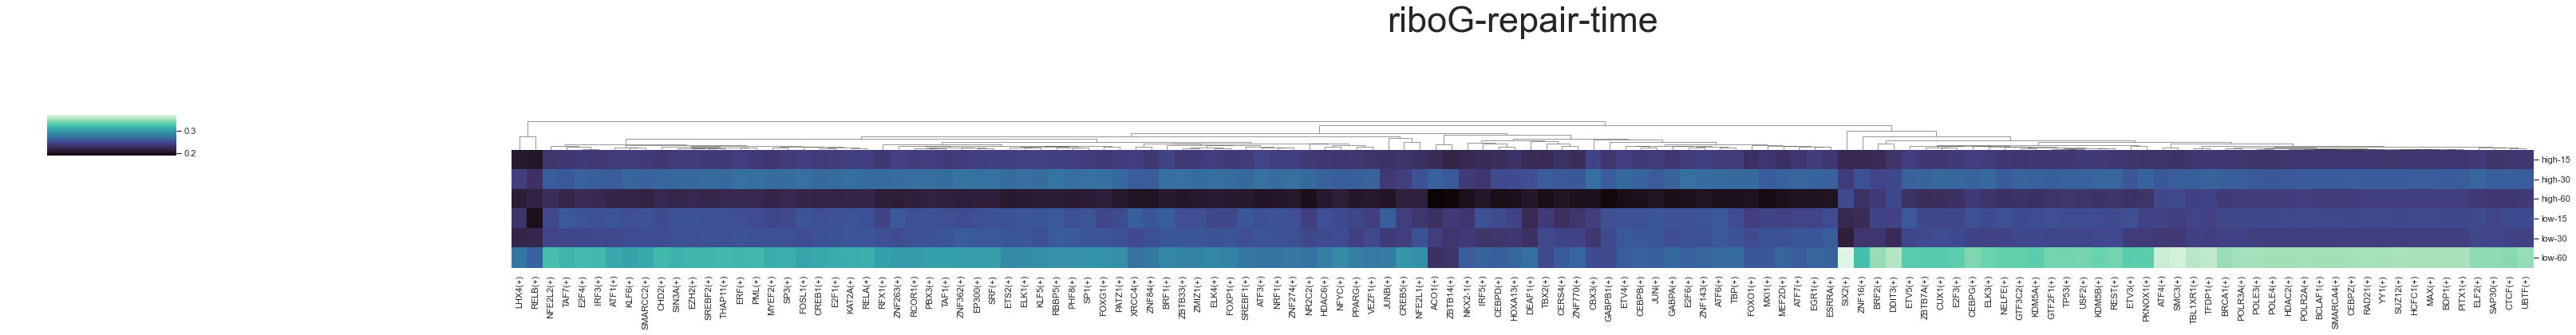

In [18]:
u = sns.clustermap(rss_dU.loc[:,np.sum(rss_dU > 0.26) > 0].sort_index(),figsize=(45,4),
                   row_cluster=False,
                   cmap="mako",
                  )
_ = u.ax_heatmap.set_yticklabels(u.ax_heatmap.get_yticklabels(), rotation=0)
_ = u.ax_heatmap.set_title('riboG-repair-time\n\n\n',fontsize=45)

Create heatmap with binarized regulon activity.

In [30]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [43]:
adata_rG = adata[adata.obs['riboG-repair'] != 'none']
adata_dU = adata[adata.obs['Uracil-repair'] != 'none']

In [53]:
adata_rG

View of AnnData object with n_obs × n_vars = 1731 × 18292
    obs: 'time', 'Uracil-45', 'riboG-44', 'riboG-repair', 'Uracil-repair', 'Uracil-repair-time', 'riboG-repair-time'

In [54]:
adata_dU

View of AnnData object with n_obs × n_vars = 2598 × 18292
    obs: 'time', 'Uracil-45', 'riboG-44', 'riboG-repair', 'Uracil-repair', 'Uracil-repair-time', 'riboG-repair-time'

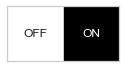

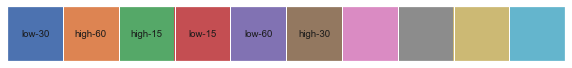

In [80]:
adata = adata_dU.copy()
label = 'Uracil-repair-time'

N_COLORS = len(set(adata.obs[label]))
COLORS = [color['color'] for color in mpl.rcParams["axes.prop_cycle"]]

cell_type_color_lut = dict(zip(set(adata.obs[label]), COLORS))
cell_id2cell_type_lut = adata_rG.obs[label].to_dict()
bw_palette = sns.xkcd_palette(["white", "black"])

sns.set()
sns.set_style("whitegrid")
fig = palplot(bw_palette, ['OFF', 'ON'], ['k', 'w'])
# savesvg('legend - GSE115978 - on_off.svg', fig)

sns.set()
sns.set(font_scale=0.8)
fig = palplot(sns.color_palette(COLORS), set(adata.obs[label]), size=1.0)
# savesvg('legend - GSE115978 - cell_type_colors.svg', fig)

In [36]:
mkdir SCENIC/figures

mkdir: SCENIC/figures: File exists


In [37]:
# sns.set()
# sns.set(font_scale=1.0)
# sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
# g = sns.clustermap(bin_mtx.T.loc[:,adata.obs['riboG-repair'] != 'none'], 
#                col_colors=auc_mtx.loc[adata.obs['riboG-repair'] != 'none',:].index.map(cell_id2cell_type_lut).map(cell_type_color_lut),
#                cmap=bw_palette, figsize=(20,20))
# g.ax_heatmap.set_xticklabels([])
# g.ax_heatmap.set_xticks([])
# g.ax_heatmap.set_xlabel('Cells')
# g.ax_heatmap.set_ylabel('Regulons')
# g.ax_col_colors.set_yticks([0.5])
# g.ax_col_colors.set_yticklabels(['Cell Type'])
# g.cax.set_visible(False)
# g.fig.savefig(os.path.join(FIGURES_FOLDERNAME, 'clustermap.pdf'), format='pdf')

In [129]:
# regulons = [
#     'SIX2(+)','DDIT3(+)',
# #     'ATF4(+)', 
# #     'NFYB(+)', 'NFYC(+)', 'ATF6(+)', 'ATF3(+)', 
# #     'NFYA(+)', 'FOXD1(+)', 'CEBPB(+)', 'PAX2(+)'
# ]

# sns.set()
# sns.set(font_scale=1.0)
# sns.set_style("ticks", {"xtick.minor.size": 1, "ytick.minor.size": 0.1})
# data = bin_mtx.T.loc[regulons,adata_rG.obs.index]
# g = sns.clustermap(
#     data,col_colors=data.columns.map(cell_id2cell_type_lut).map(cell_type_color_lut),
#     cmap=bw_palette, figsize=(20,6)
# )

# g.ax_heatmap.set_xticklabels([])
# g.ax_heatmap.set_xticks([])
# g.ax_heatmap.set_xlabel('Cells')
# g.ax_heatmap.set_ylabel('Regulons')
# g.ax_col_colors.set_yticks([0.5])
# g.ax_col_colors.set_yticklabels(['Cell Type'])
# g.cax.set_visible(False)
# # g.fig.savefig(os.path.join(FIGURES_FOLDERNAME, 'clustermap.pdf'), format='pdf')

Save clustered binarized heatmap to Excel for further inspection.

In [131]:
# bin_mtx_clustered = bin_mtx.T.copy()

In [132]:
# bin_mtx_clustered.iloc[g.dendrogram_row.reordered_ind, g.dendrogram_col.reordered_ind].to_csv(os.path.join(RESULTS_FOLDERNAME, 'binarized-regulon-activity.csv'))

Generate sequence logos.

In [133]:
def derive_regulons(motifs):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))
#     return motifs

In [135]:
regulons = derive_regulons(df_motifs)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [136]:
def fetch_logo(regulon, base_url = BASE_URL):
    for elem in regulon.context:
        if elem.endswith('.png'):
            return '<img src="{}{}" style="max-height:124px;"></img>'.format(base_url, elem)
    return ""

In [137]:
df_regulons = pd.DataFrame(data=[list(map(op.attrgetter('name'), regulons)),
                                 list(map(len, regulons)),
                                 list(map(fetch_logo, regulons))], index=['name', 'count', 'logo']).T

In [138]:
# df_regulons

In [141]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons[df_regulons.name == 'DDIT3'].to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

/Users/abearab/anaconda3/envs/sc-net/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,name,count,logo


In [297]:
pd.concat(
    [adjacencies[(adjacencies.TF == 'POLR2A') & (adjacencies.target == 'UNG')],
     adjacencies[(adjacencies.TF == 'POLR2A') & (adjacencies.target == 'RNASEH2A')]
    ],axis=0
)    

,TF,target,importance
1203230,POLR2A,UNG,0.002283
3511404,POLR2A,RNASEH2A,0.001305


In [167]:
MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1)
display(HTML(df_regulons[df_regulons.name == 'DDIT3'].to_html(escape=False)))
pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

,name,count,logo


In [298]:
pd.concat(
    [adjacencies[(adjacencies.TF == 'DDIT3') & (adjacencies.target == 'UNG')],
     adjacencies[(adjacencies.TF == 'DDIT3') & (adjacencies.target == 'RNASEH2A')]
    ],axis=0
)    

,TF,target,importance
2613512,DDIT3,UNG,0.001543
7842277,DDIT3,RNASEH2A,0.000756


In [373]:
# MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
# pd.set_option('display.max_colwidth', -1)
# display(HTML(df_regulons.head().to_html(escape=False)))
# pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

### STEP 6: Non-linear projection and clustering

In this step a `scanpy.AnnData` object is created containing all metadata and results.

First, we select and retain only the most variable genes in the dataset.

## __PCA + tSNE PROJECTION__

In [299]:
sns.set()

In [300]:
bdata = ad.AnnData(auc_mtx,adata.obs)

In [301]:
bdata

AnnData object with n_obs × n_vars = 4865 × 268
    obs: 'time', 'Uracil-45', 'riboG-44', 'riboG-repair', 'Uracil-repair'

In [302]:
# sc.pp.highly_variable_genes(adata)
# sc.pl.highly_variable_genes(adata)
# adata = adata[:, adata.var['highly_variable']]

Then we apply a linear-dimensional reduction technique (PCA).

In [1]:
# sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata, color='UNG')

In [2]:
# sc.pl.pca_variance_ratio(adata, log=True)

Followed by a tSNE projection.

In [4]:
# sc.tl.tsne(adata)

In [5]:
# adata

In [6]:
# sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
# sc.pl.tsne(adata, color=['time', 'Uracil-45', 'riboG-44', 'riboG-repair', 'Uracil-repair'], 
# #            title=['GSE115978 - SKCM - Cell types', 'GSE115978 - SKCM - Lesion types',
# #                  'GSE115978 - SKCM - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=3, palette=COLORS,
# #           save=''
#           )

We capture the non-linear projection based on PCA+tSNE for later storage in the loom file.

In [7]:
# embedding_pca_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

We add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [8]:
# add_scenic_metadata(adata, auc_mtx, regulons)
# adata.write_h5ad(ANNDATA_FNAME)

We change the tSNE projection so that it relies on AUCell instead of PCA.

In [9]:
# sc.tl.tsne(adata, use_rep='X_aucell')

In [10]:
# embedding_aucell_tsne = pd.DataFrame(adata.obsm['X_tsne'], columns=[['_X', '_Y']], index=adata.obs_names)

In [11]:
# sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
# sc.pl.tsne(adata, color=['time', 'Uracil-45', 'riboG-44', 'riboG-repair', 'Uracil-repair'], 
# #            title=['GSE103322 - HNSC - Cell types', 'GSE103322 - HNSC - Lesion types',
# #                  'GSE103322 - HNSC - {} patients'.format(len(adata.obs.patient_id.unique()))], ncols=3,
# #           save=''
#           )

__CELL TYPE SPECIFIC REGULATORS - RSS__

In [12]:
# auc_mtx = pd.read_csv(f'{AUCELL_MTX_FNAME}',index_col='Cell')

In [13]:
# rss_rG = regulon_specificity_scores(auc_mtx, adata.obs['riboG-repair'])
# rss_rG.head()

In [14]:
# rss_dU = regulon_specificity_scores(auc_mtx, adata.obs['Uracil-repair'])
# rss_dU.head()

In [15]:
# rss = regulon_specificity_scores(auc_mtx, adata.obs['time'])
# rss.head()

In [16]:
# help(plot_rss)

In [17]:
# sns.set()
# sns.set(style='whitegrid', font_scale=0.8)
# fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 6), dpi=100)
# plot_rss(rss_rG, 'low', ax=ax1)
# ax1.set_xlabel('')
# plot_rss(rss_rG, 'high', ax=ax2)
# ax2.set_xlabel('')
# ax2.set_ylabel('')
# plot_rss(rss_dU, 'low', ax=ax3)
# ax3.set_xlabel('')
# ax3.set_ylabel('')
# plot_rss(rss_dU, 'high', ax=ax4)
# ax4.set_xlabel('')
# ax4.set_ylabel('')
# plot_rss(rss, 15, ax=ax5)
# plot_rss(rss, 30, ax=ax6)
# ax6.set_ylabel('')
# plot_rss(rss, 60, ax=ax7)
# ax7.set_ylabel('')
# # plot_rss(rss, 60, ax=ax8)
# # ax8.set_ylabel('')
# plt.tight_layout()
# # FIGURES_FOLDERNAME
# fig.savefig(os.path.join(FIGURES_FOLDERNAME, 'rss.pdf'), format='pdf')

__CELL TYPE SPECIFIC REGULATORS - Z-SCORE__

To find cell type specific regulators we use a Z score (i.e. the average AUCell score for the cells of a give type are standardized using the overall average AUCell scores and its standard deviation).

In [18]:
# def make_df_results(group):
#     df_obs = adata.obs
#     signature_column_names = list(df_obs.select_dtypes('number').columns)
#     signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
#     df_scores = df_obs[signature_column_names + [group]]
#     df_results = ((df_scores.groupby(by=group).mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
#     df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
    
#     return df_results

In [19]:
# df_results_by_time = make_df_results('time')

In [20]:
# df_results_by_rG = make_df_results('riboG-repair')

# df_results_by_rG[(abs(df_results_by_rG.Z) >= 0.27)].sort_values('Z', ascending=False)

In [21]:
# df_results_by_dU = make_df_results('Uracil-repair')

# df_results_by_dU[(abs(df_results_by_dU.Z) >= 0.35)].sort_values('Z', ascending=False)

In [22]:
# for phenotype in ['Uracil-repair','riboG-repair']:
#     for size in ['low','high']:
#         for time in [15,30,60]:
#             fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
#             sc.pl.tsne(
#                 adata[(adata.obs.time == time) & (adata.obs[phenotype] == size)],
#                 color='Regulon(DDIT3(+))',
#                 title=f'DDIT3(+) at {str(time)}\' - {size} {phenotype}',
#                 use_raw=False,ax=ax
#             # #     save=''
#             )

In [23]:
# for phenotype in ['Uracil-repair','riboG-repair']:
#     for size in ['low','high']:
#         for time in [15,30,60]:
#             fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
#             sc.pl.tsne(
#                 adata[(adata.obs.time == time) & (adata.obs[phenotype] == size)],
#                 color='Regulon(POLR2A(+))',
#                 title=f'POLR2A(+) at {str(time)}\' - {size} {phenotype}',
#                 use_raw=False,ax=ax
#             # #     save=''
#             )

### STEP 7: Export to SCope

In [321]:
# bin_mtx, thresholds = binarize(auc_mtx)
# bin_mtx.to_csv(BIN_MTX_FNAME)
# thresholds.to_frame().rename(columns={0:'threshold'}).to_csv(THR_FNAME)

In [24]:
# bin_mtx = pd.read_csv(BIN_MTX_FNAME, index_col=0)
# thresholds = pd.read_csv(THR_FNAME, index_col=0).threshold

In [25]:
# export2loom(adata.to_df(), regulons, LOOM_FNAME,
#             cell_annotations=adata.obs['time'].to_dict(),
#             embeddings=OrderedDict([('AUCell + tSNE', embedding_aucell_tsne), ('PCA + tSNE', embedding_pca_tsne)]),
#             auc_mtx = auc_mtx,
#             tree_structure=(),
#             nomenclature="HGNC", auc_thresholds=thresholds,
#             compress=True)

# dynGENIE3

- `TS_data` is a list of 3 arrays, each array corresponding to a time series experiment. The number of time points (rows) does not need to be the same in all the experiments, but the number of genes (columns) must be the same.
- `time_points` is a list of 3 vectors, containing the corresponding time points.
- `decay_rates` is a vector containing gene decay rates.
- `genes_names` is a list containing the names of the genes.

In [1]:
from dynGENIE3 import *

/Users/abearab/anaconda3/envs/sc-analysis/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
help(dynGENIE3)

Help on function dynGENIE3 in module dynGENIE3:

dynGENIE3(TS_data, time_points, alpha='from_data', SS_data=None, gene_names=None, regulators='all', tree_method='RF', K='sqrt', ntrees=1000, compute_quality_scores=False, save_models=False, nthreads=1)
    Computation of tree-based scores for all putative regulatory links.
    
    Parameters
    ----------
    
    TS_data: list of numpy arrays
        List of arrays, where each array contains the gene expression values of one time series experiment. Each row of an array corresponds to a time point and each column corresponds to a gene. The i-th column of each array must correspond to the same gene.
    
    time_points: list of one-dimensional numpy arrays
        List of n vectors, where n is the number of time series (i.e. the number of arrays in TS_data), containing the time points of the different time series. The i-th vector specifies the time points of the i-th time series of TS_data.
    
    alpha: either 'from_data', a positiv

In [3]:
help(dynGENIE3_predict_doubleKO)

Help on function dynGENIE3_predict_doubleKO in module dynGENIE3:

dynGENIE3_predict_doubleKO(expr_WT, treeEstimators, alpha, gene_names, regulators, KO1_gene, KO2_gene, nTimePoints, deltaT)
    Prediction of gene expressions in a double knockout experiment.
    
    Parameters
    ----------
    
    expr_WT: vector containing the gene expressions in the wild-type.
    
    treeEstimators: list of tree models, as returned by the function dynGENIE3(), where the i-th model is the model predicting the expression of the i-th gene. 
        The i-th model must correspond to the i-th gene in expr_WT.
    
    alpha: a positive number or a vector of positive numbers
        Specifies the degradation rate of the different gene expressions. 
        When alpha is a vector of positives, the i-th element of the vector must specify the degradation rate of the i-th gene.
        When alpha is a positive number, all the genes are assumed to have the same degradation rate.
    
    gene_names: list o

In [ ]:
(VIM, alphas, prediction_score, stability_score, treeEstimators) = dynGENIE3(TS_data,time_points)

- `VIM` is an array containing the scores of the putative regulatory links. $VIM(i,j)$
is the weight of the link directed from the $i$-th gene to $j$-th gene.
- `alphas` is a vector in which the i-th element is the decay rate of the $i$-th gene. By default, the decay rate αi of gene i is estimated from its time series data, by assuming an exponential decay $e^{{−α}_it}$ between the highest and lowest observed expression values of gene i.
- `prediction_score` is an empty list by default.
- `stability_score` is an empty list by default.
- `treeEstimators` is an empty list by default.